<a href="https://colab.research.google.com/github/nicolaerosca/colab_notebooks/blob/master/PyTorch_cifar10_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

In [3]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

tcmalloc: large alloc 1073750016 bytes == 0x5747a000 @  0x7faef8f012a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [4]:
print(torch.__version__)

0.4.1


In [0]:
torch.cuda.is_available()

True

In [13]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

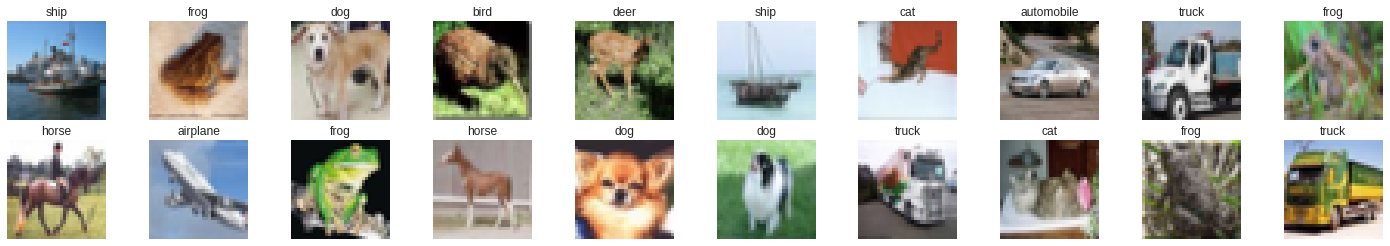

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [0]:
torch.arange(1,10+1)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict


class _DenseLayer(nn.Sequential):
  """
  A DenseBlock contains multiple DenseLayer s, each layer has:
    
  BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) 
  In our experiments, we let each 1×1 convolution produce 4k feature-maps.

  """
  
  def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
    """
    num_input_features - 
    growth_rate - described like k in the paper
    bn_size - bottleneck size (bn_size * k features in the bottleneck layer)
    drop_rate - dropout [0,1] rate
    
    """
    super(_DenseLayer, self).__init__()
    self.add_module("norm1", nn.BatchNorm2d(num_input_features))
    self.add_module("relu1", nn.ReLU(inplace=True))
    self.add_module("conv1", nn.Conv2d(num_input_features, bn_size*growth_rate, kernel_size=1, stride=1, bias=False))
    self.add_module("norm2", nn.BatchNorm2d(bn_size*growth_rate))
    self.add_module("relu2", nn.ReLU(inplace=True))
    self.add_module("conv2", nn.Conv2d(bn_size*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False))
    self.drop_rate = drop_rate
    
  def forward(self, x):
    new_features = super(_DenseLayer, self).forward(x)
#     print(x.shape)
#     print(new_features.shape)
    if self.drop_rate > 0:
      new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
    return torch.cat([x, new_features], 1)


  
  
class _DenseBlock(nn.Sequential):
  """
  It is a DenseBlock described in paper. Contains multiple DenseLayers
  """
  
  def __init__(self, n_layers, num_input_features, growth_rate, bn_size, drop_rate):
    """
    n_layers - number of dense layers
      
    """
    super(_DenseBlock, self).__init__()
    for i in range(n_layers):
      layer = _DenseLayer(num_input_features + growth_rate*i, growth_rate, bn_size, drop_rate)
      self.add_module("layer%d" % (i+1), layer)

      

class _TransitionBlock(nn.Sequential):
  def __init__(self, num_input_features, num_output_features):
    super(_TransitionBlock, self).__init__()
    self.add_module('norm', nn.BatchNorm2d(num_input_features))
    self.add_module('relu', nn.ReLU(inplace=True))
    self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                      kernel_size=1, stride=1, bias=False))
    self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2)) 



class DenseNet(nn.Module):
  """
  DenseNet-BN from famous paper from 2016 with bottleneck of 4
  num_init_features - number of features after first convolution, 16 for CIFAR, 64 for ImageNet ( or twice growth_rate)
  
  """
  def __init__(self, num_init_features, growth_rate, dense_blocks, bn_size, num_classes, drop_rate=0):
    super(DenseNet, self).__init__()

    # First convolution
    self.features = nn.Sequential(OrderedDict([
        ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
        ('norm0', nn.BatchNorm2d(num_init_features)),
        ('relu0', nn.ReLU(inplace=True)),
        ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))
    
    
    # for each dense block
    num_features = num_init_features
    for i, num_layers in enumerate(dense_blocks):
      block = _DenseBlock(num_layers, num_features, growth_rate, bn_size, drop_rate)
      self.features.add_module("dense_block%d" % (i+1), block)
      num_features = num_features + num_layers * growth_rate
      # skip last tranition block
      if i != len(dense_blocks) - 1:
        trans = _TransitionBlock(num_input_features=num_features, num_output_features=num_features // 2)
        self.features.add_module('transition%d' % (i + 1), trans)
        num_features = num_features // 2
    
    # fully conected
    # Final batch norm
    self.features.add_module('norm_last', nn.BatchNorm2d(num_features))

    # Linear layer
    self.classifier = nn.Linear(num_features, num_classes)

    # Official init from torch repo.
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal(m.weight.data)
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.bias.data.zero_()

  def forward(self, x):
    features = self.features(x)
    out = F.relu(features, inplace=True)
    out = F.avg_pool2d(out, kernel_size=2, stride=1).view(features.size(0), -1)
    out = self.classifier(out)
    return out

    
# create a CIFAR-10 DenseNet
model = DenseNet(num_init_features=16, growth_rate=24, dense_blocks=(6,24,24), bn_size=4, num_classes=10, drop_rate=0 )
print(model)

# move tensors to GPU if CUDA is available
if torch.cuda.is_available():
    model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (dense_block1): _DenseBlock(
      (layer1): _DenseLayer(
        (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(96, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (layer2): _DenseLayer(
        (norm1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (

In [0]:
# debug model size
def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())


model.features.conv0.register_forward_hook(printnorm)
dummy_data = torch.randn(20, 3, 32, 32)
dummy_data.cuda()
model(dummy_data)

In [0]:
torch.randn(20, 3, 32, 32).view(-1,3*32*32).shape

torch.Size([20, 3072])

In [0]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.03)
optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9,nesterov=True)

Train

In [9]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu 

True

In [10]:
# number of epochs to train the model
n_epochs = 100 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.321076 	Validation Loss: 0.277631
Validation loss decreased (inf --> 0.277631).  Saving model ...
Epoch: 2 	Training Loss: 1.020098 	Validation Loss: 0.224188
Validation loss decreased (0.277631 --> 0.224188).  Saving model ...
Epoch: 3 	Training Loss: 0.867309 	Validation Loss: 0.198994
Validation loss decreased (0.224188 --> 0.198994).  Saving model ...
Epoch: 4 	Training Loss: 0.760846 	Validation Loss: 0.183136
Validation loss decreased (0.198994 --> 0.183136).  Saving model ...
Epoch: 5 	Training Loss: 0.676878 	Validation Loss: 0.171503
Validation loss decreased (0.183136 --> 0.171503).  Saving model ...
Epoch: 6 	Training Loss: 0.615688 	Validation Loss: 0.167043
Validation loss decreased (0.171503 --> 0.167043).  Saving model ...
Epoch: 7 	Training Loss: 0.591054 	Validation Loss: 0.157122
Validation loss decreased (0.167043 --> 0.157122).  Saving model ...
Epoch: 8 	Training Loss: 0.515395 	Validation Loss: 0.154828
Validation loss decreased (0.15712

KeyboardInterrupt: ignored

In [0]:
for i, weights in enumerate(list(model.parameters())):
    print('i:',i,'weights:',weights.size())

In [14]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.846804

Test Accuracy of airplane: 83% (838/1000)
Test Accuracy of automobile: 78% (782/1000)
Test Accuracy of  bird: 61% (612/1000)
Test Accuracy of   cat: 60% (600/1000)
Test Accuracy of  deer: 71% (714/1000)
Test Accuracy of   dog: 59% (599/1000)
Test Accuracy of  frog: 79% (799/1000)
Test Accuracy of horse: 79% (795/1000)
Test Accuracy of  ship: 84% (843/1000)
Test Accuracy of truck: 88% (887/1000)

Test Accuracy (Overall): 74% (7469/10000)


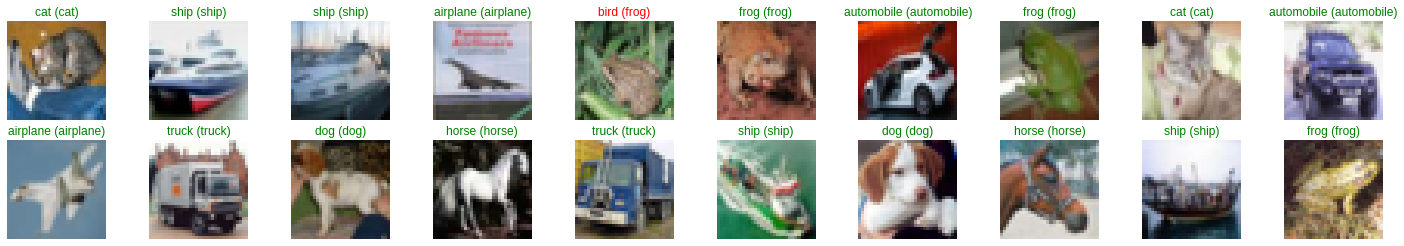

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))